# Benchmarking

## 1. Prepare working environment

In [1]:
import timm
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
import os

from scripts import Worker

In [2]:
!nvidia-smi

Mon Mar 13 04:06:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.89.02    Driver Version: 525.89.02    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:8A:00.0 Off |                  N/A |
| 49%   26C    P8    18W / 320W |      0MiB / 10240MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 2. Datasets and visulisation

In [4]:
class MyDataset(Dataset):
    def __init__(self, data_dir, transforms=None):
        self.data_dir = data_dir
        self.data_info = self.get_img_info(data_dir)
        self.transforms = transforms

    def __getitem__(self, item):
        path_img, label = self.data_info.iloc[item][1:3]
        label = int(label)
        path_img = os.path.join(self.data_dir, path_img)
        image = Image.open(path_img).convert('RGB')
        # 使用定义好的transforms，对数据进行处理
        if self.transforms is not None:
            image = self.transforms(image)

        return image, label

    def __len__(self):
        return len(self.data_info)
    
    def get_img_info(self, data_dir):
        path_dir = os.path.join(data_dir, 'label.csv')
        return pd.read_csv(path_dir)

In [5]:
dataset_folder = "dataset01"

transform = transforms.Compose(
    [transforms.ToTensor()])
    #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

trainset = MyDataset(f"data/train/{dataset_folder}", transform)
testset = MyDataset(f"data/test/{dataset_folder]", transform)

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=8)

# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=8)

classes = (0, 1)

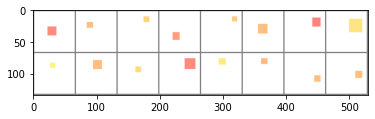

    0     1     0     0     0     1     0     0     0     0     0     0     0     0     1     1


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# 输出图像的函数
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 随机获取训练图片
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 显示图片
imshow(torchvision.utils.make_grid(images))
# 打印图片标签
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))


## 3. Model and training

In [7]:
timm.list_models('vgg*', pretrained=True)

['vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19',
 'vgg19_bn']

In [142]:
exp_name = "dataset01_benchmarking"
model_names = ['xception','densenet121','resnet50', 'vgg16','darknet53', ]

In [10]:
for model_name in model_names:
    print(model_name)
    model = timm.create_model(model_name, num_classes=2)
    worker = Worker(exp_name, model_name, model, trainloader, testloader, epochs=1)
    worker.train()

xception


epoch,train_loss,valid_loss,accuracy,time
0,0.452599,0.402864,0.777500,00:36


epoch,train_loss,valid_loss,accuracy,time
0,0.283464,0.176538,0.931000,00:36


densenet121


epoch,train_loss,valid_loss,accuracy,time
0,0.367142,0.271392,0.827500,01:36


epoch,train_loss,valid_loss,accuracy,time
0,0.138623,0.138133,0.950000,01:35


resnet50


epoch,train_loss,valid_loss,accuracy,time
0,0.432746,0.475688,0.750000,00:42


epoch,train_loss,valid_loss,accuracy,time
0,0.170265,0.157058,0.938500,00:42


vgg16


epoch,train_loss,valid_loss,accuracy,time
0,52.740898,0.618975,0.695500,00:39


epoch,train_loss,valid_loss,accuracy,time
0,0.627065,0.614672,0.695500,00:39


darknet53


epoch,train_loss,valid_loss,accuracy,time
0,0.538166,1.617648,0.695500,00:44


epoch,train_loss,valid_loss,accuracy,time
0,0.202158,0.170572,0.935000,00:45


## 4. Metrics

In [146]:
from fastai.vision import *
from fastai.data.transforms import *


exp_name = "dataset01_benchmarking"
model_names = ['xception','densenet121','resnet50', 'vgg16','darknet53']

benchmark_dict = {}

for model_name in model_names:
    print(model_name)
    
    benchmark_dict[model_name] = pd.DataFrame(columns = ["value", "type"])
    
    state_dict = torch.load(f"models/{exp_name}/{model_name}.pt")

    model = timm.create_model(model_name, num_classes=2)
    model.load_state_dict(state_dict)

    worker = Worker(exp_name, model_name, model, trainloader, testloader)
    worker.eval()
    
    path_dir = os.path.join(f"data/test/{dataset_folder}", 'label.csv')
    info_df = pd.read_csv(path_dir)

    testiter = iter(testloader)

    FN_values = []
    FP_values = []
    TP_values = []
    TN_values = []

    for i in range(info_df.size-1):
        images, labels = next(testiter, (None, None))

        if images == None or labels == None:
            break

        label = info_df.iloc[i][2]
        value = info_df.iloc[i][7]
        images = images.to(device)
        pred = worker.learner.model(images).argmax(1)[0]
        if (pred != label):
            if (label == 0):
                benchmark_dict[model_name].loc[len(benchmark_dict[model_name]), benchmark_dict[model_name].columns] = value, 'FN'
            else:
                benchmark_dict[model_name].loc[len(benchmark_dict[model_name]), benchmark_dict[model_name].columns] = value, 'FP'
                
        else:
            if (label == 0):
                benchmark_dict[model_name].loc[len(benchmark_dict[model_name]), benchmark_dict[model_name].columns] = value, 'TN'
                
            else:
                benchmark_dict[model_name].loc[len(benchmark_dict[model_name]), benchmark_dict[model_name].columns] = value, 'TP'
                

xception


epoch,train_loss,valid_loss,accuracy,time
0,0.111140,0.077574,0.981000,00:37


densenet121


epoch,train_loss,valid_loss,accuracy,time
0,0.104075,0.085437,0.972000,01:37


resnet50


epoch,train_loss,valid_loss,accuracy,time
0,0.094447,0.118962,0.960500,00:42


vgg16


epoch,train_loss,valid_loss,accuracy,time
0,0.618091,0.614809,0.695500,00:39


darknet53


epoch,train_loss,valid_loss,accuracy,time
0,0.155938,0.139674,0.958000,00:45


/root/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


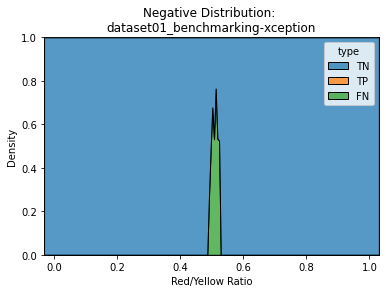

/root/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


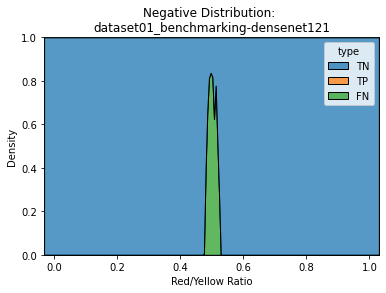

/root/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


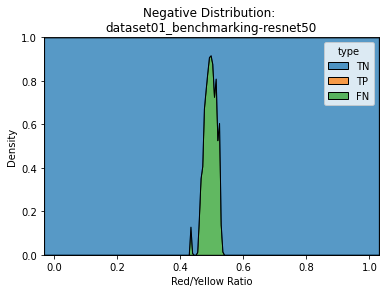

/root/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


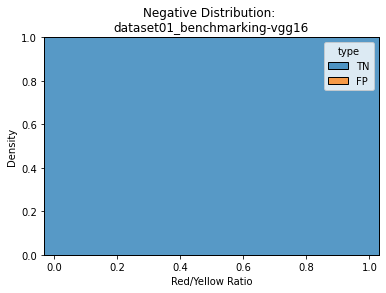

/root/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


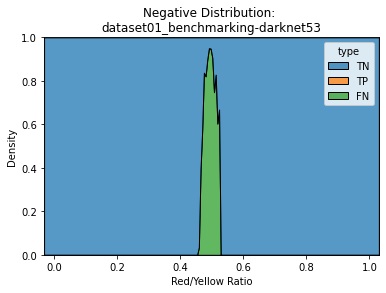

In [156]:
import seaborn as sns

for model_name in model_names:
    sns.kdeplot(data=benchmark_dict[model_name], x='value', hue='type', multiple='fill', bw_adjust = 0.2)

    # plt.legend(['False Negative', 'True Negative'])
    plt.xlabel ("Red/Yellow Ratio");
    # plt.ylabel ("");
    plt.title (f"Negative Distribution: \n{exp_name}-{model_name}");
    plt.show()

# 